# Predicting Financial Market

- 在这个练习中我们利用决策树、随机森林等非参数方法对金融市场数据进行预测，并将非参数方法的结果与计量经济学中的时间序列模型进行对比。

- 所用数据为美国金融市场主要股票指数与宏观经济指标在过去23年的数据。

- 数据的观测频率为每日的收盘价。

### 读入数据并导入分析需要用到的软件包

In [3]:
import os
import datetime
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller


def read_csv_space(path, file):
    return pd.read_csv(os.path.join(path, file), encoding='', sep='\s+', index_col=False, engine='python') 

def read_csv_comma(path, file):
    return pd.read_csv(os.path.join(path, file), encoding='', sep=',', engine='python') 

close_prices = read_csv_comma('c:\\users\\jiay\\nankai\\lecture 8', 'marketdata.csv')
close_prices.set_index(close_prices['Date'], inplace=True)
close_prices.drop(columns =['Date'], inplace=True)


In [4]:
close_prices

,CL=F,DX-Y.NYB,HG=F,^DJI,^GSPC,^IXIC,^RUT,^TNX,^VIX
Date,,,,,,,,,
8/30/2000,33.400002,112.139999,0.8850,11103.00977,1502.589966,4103.810059,532.330017,5.800,17.690001
8/31/2000,33.099998,112.599999,0.8850,11215.09961,1517.680054,4206.350098,537.890015,5.729,16.840000
9/1/2000,33.380001,111.419998,0.8890,11238.78027,1520.770020,4234.330078,541.909973,5.675,17.530001
9/5/2000,33.799999,112.410004,0.9060,11260.61035,1507.079956,4143.180176,539.020019,5.683,19.820000
9/6/2000,34.950001,114.120003,0.9015,11310.63965,1492.250000,4013.340088,536.320007,5.712,20.790001
...,...,...,...,...,...,...,...,...,...
10/13/2023,87.690002,106.650001,3.5800,33670.28906,4327.779785,13407.230470,1719.709961,4.629,19.320000
10/16/2023,86.660004,106.239998,3.5870,33984.53906,4373.629883,13567.980470,1747.060059,4.712,17.209999
10/17/2023,86.660004,106.250000,3.5755,33997.64844,4373.200195,13533.750000,1766.050049,4.847,17.879999


- 我们用到的数据覆盖9/1/2000 - 10/19/2023的时间范围，九个金融市场指数一天的收盘价。
- CL=F 为原油期货价格
- DX-Y.NYB 为美元指数
- HG=F 为铜期货价格
- ^DJI 为道琼斯30指数
- ^GSPC 为标准普尔500指数
- ^IXIC 为NASDAQ100指数
- ^RUT 为RUSSELL2000指数
- ^TNX 为美国10年期国债利率
- ^VIX 为金融市场恐慌指数

### 时间序列的Stationarity
- 时间序列数据与截面数据不同，独立同分布的假设在这里不适用，因为数据在时间上是相关的。
- 不仅如此，经济分析里用到的时间序列通常有一定的趋势，在不同时间点上采集的数据从而不具有可比性。严格说来，在这种情况下不同时间点上采集的数据来源于不同的概率分布。
- 时间序列分析的统计模型或机器学习算法要求序列是stationary.
- 以下是时间序列的stationarity的严格定义：  
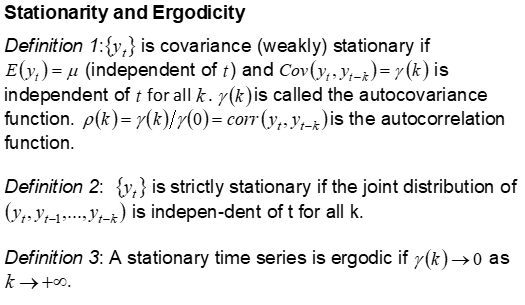

- 直观说来，一个时间序列能用来做统计分析，这个数据的分布（至少均值和方差-协方差）不能随时间变化。

### 通过画图检查时间序列是否stationary

- 检查一个时间序列是否stationary的最简单办法是画图。
- 我们利用以下代码对数据中的九个序列分别画图

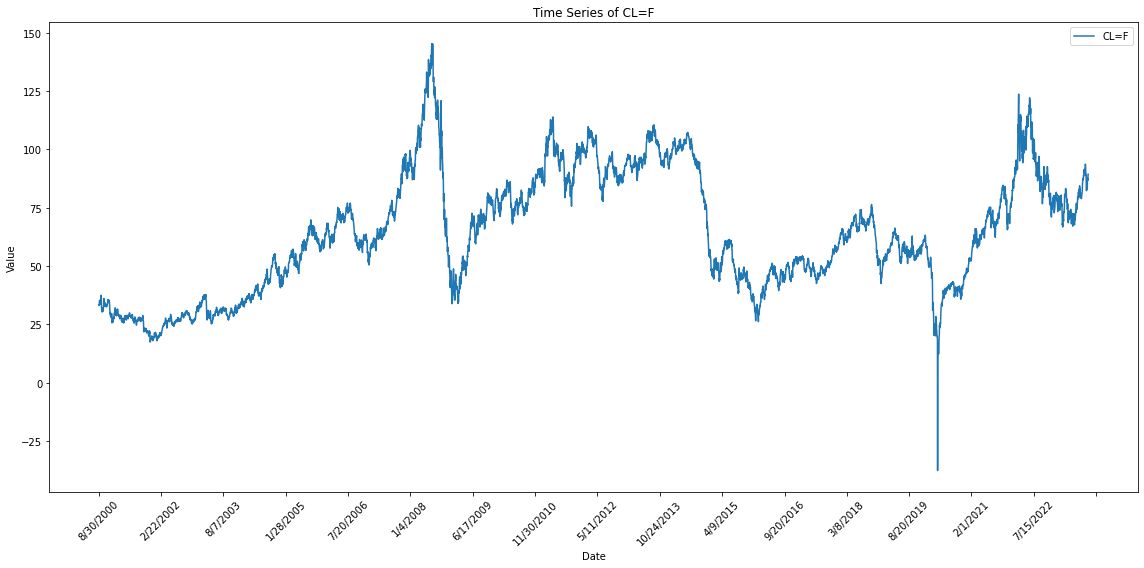

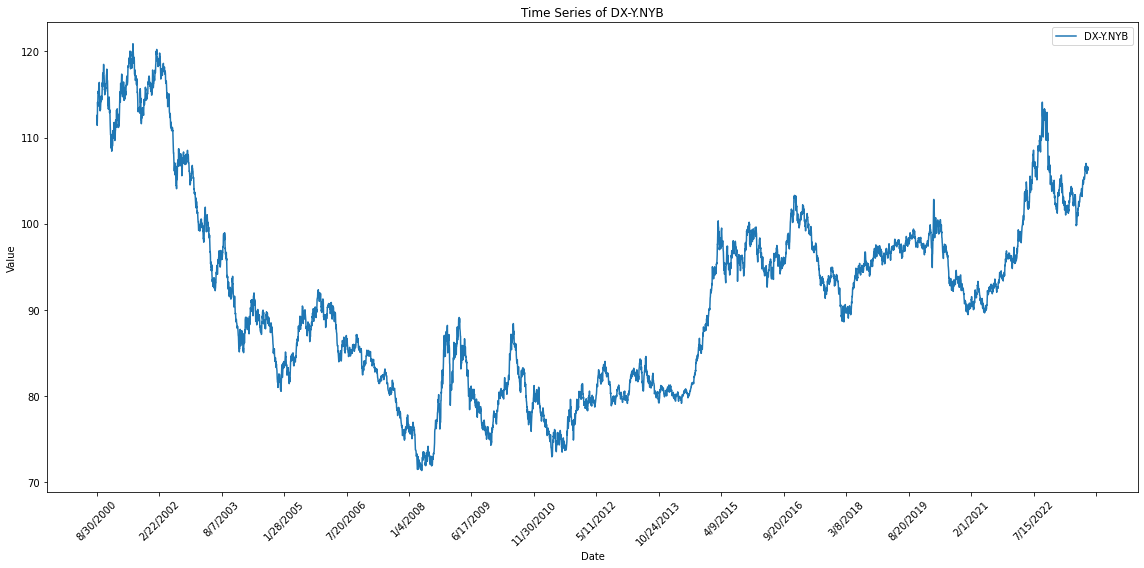

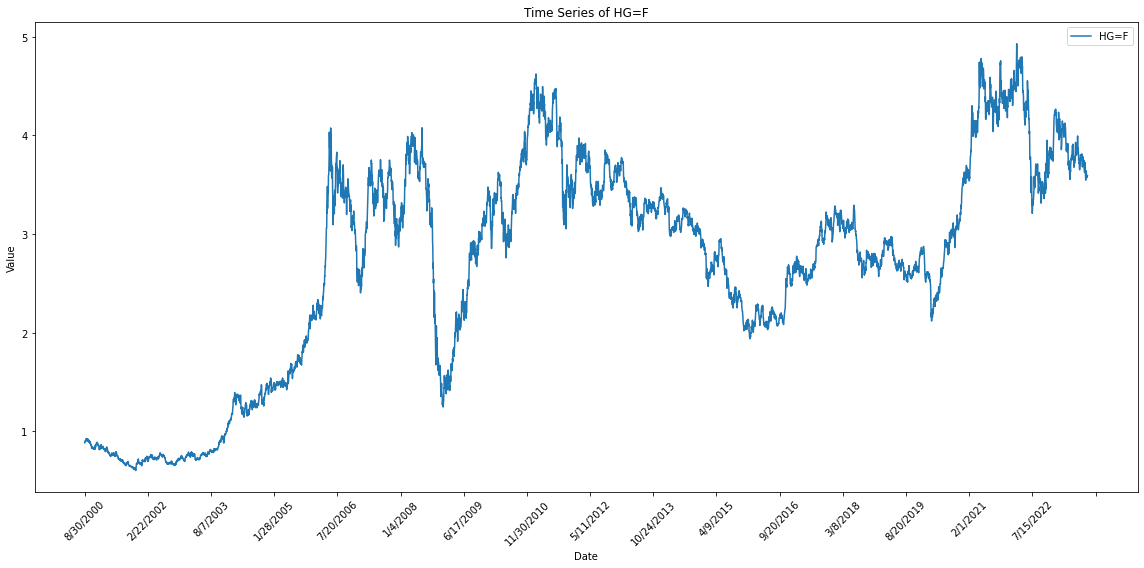

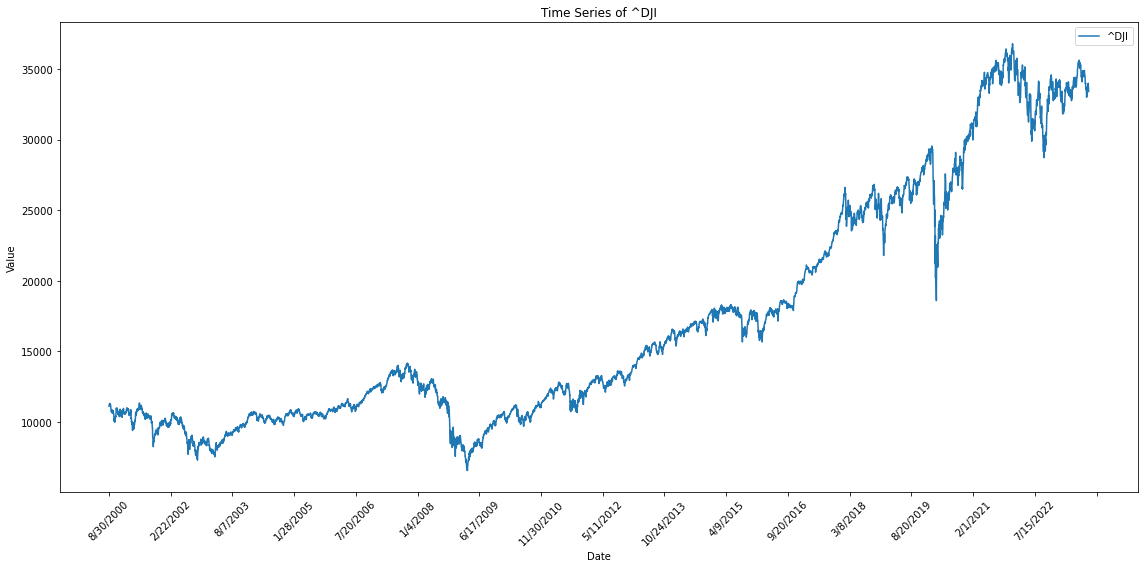

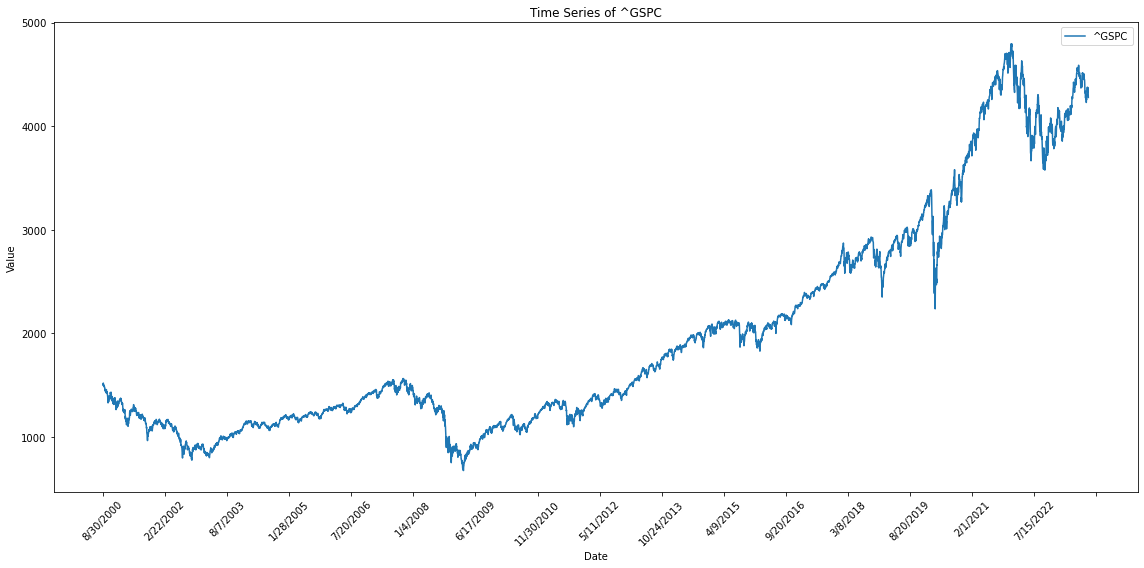

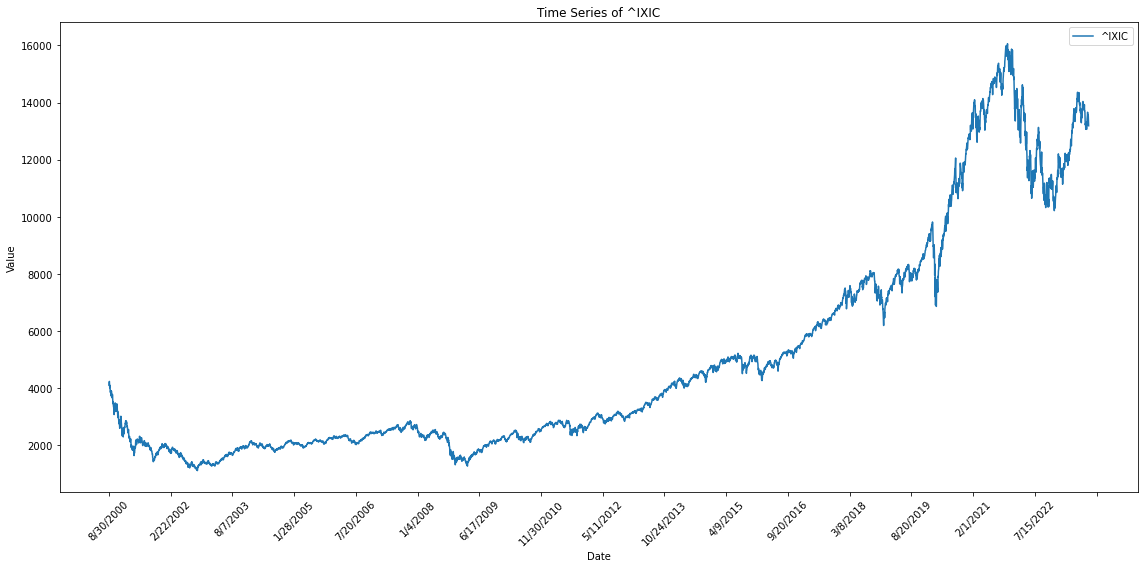

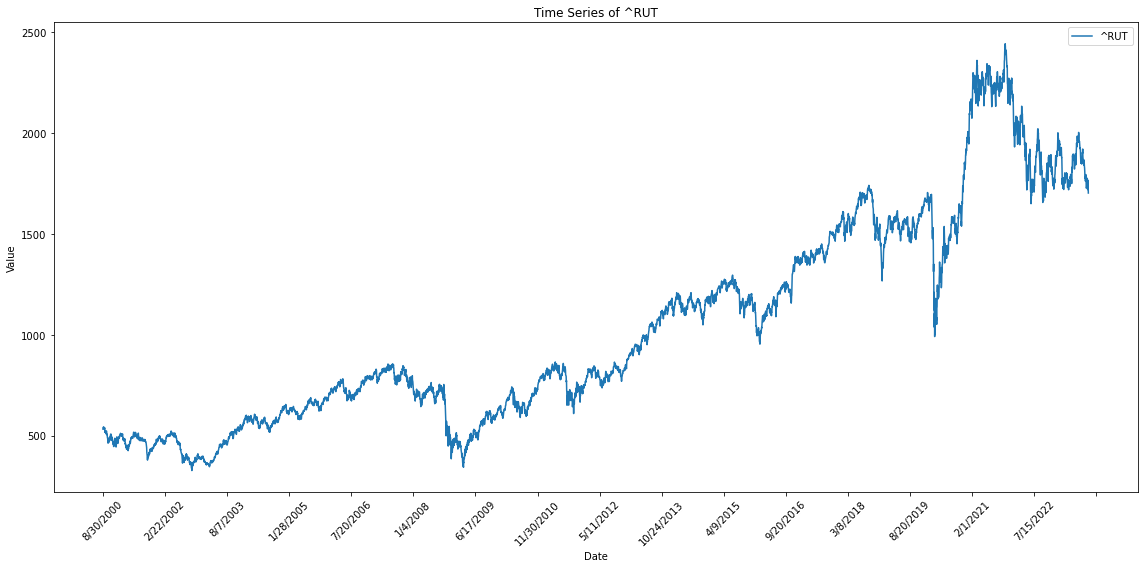

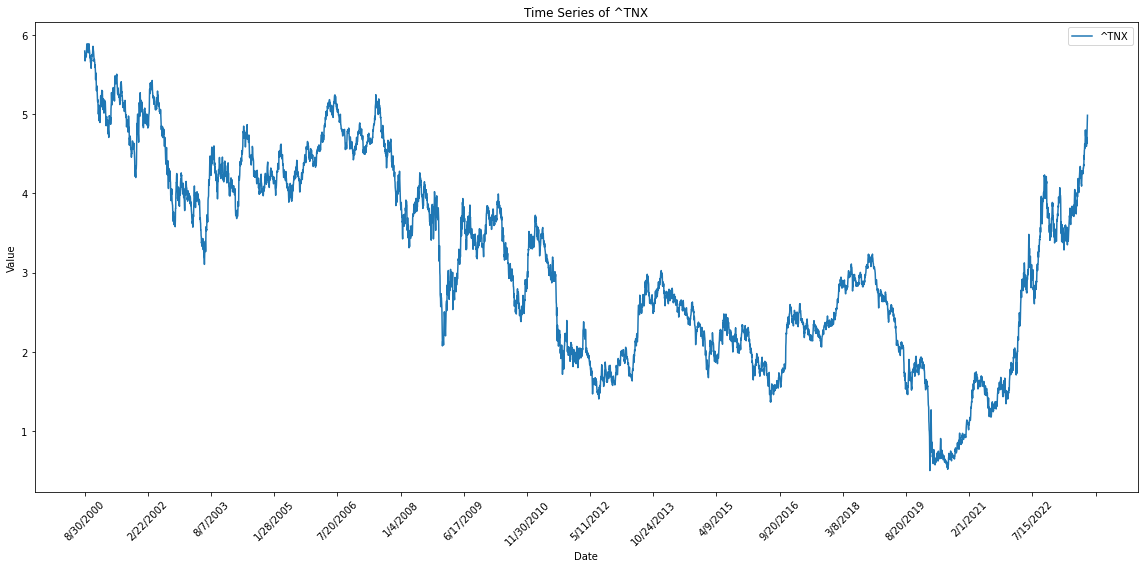

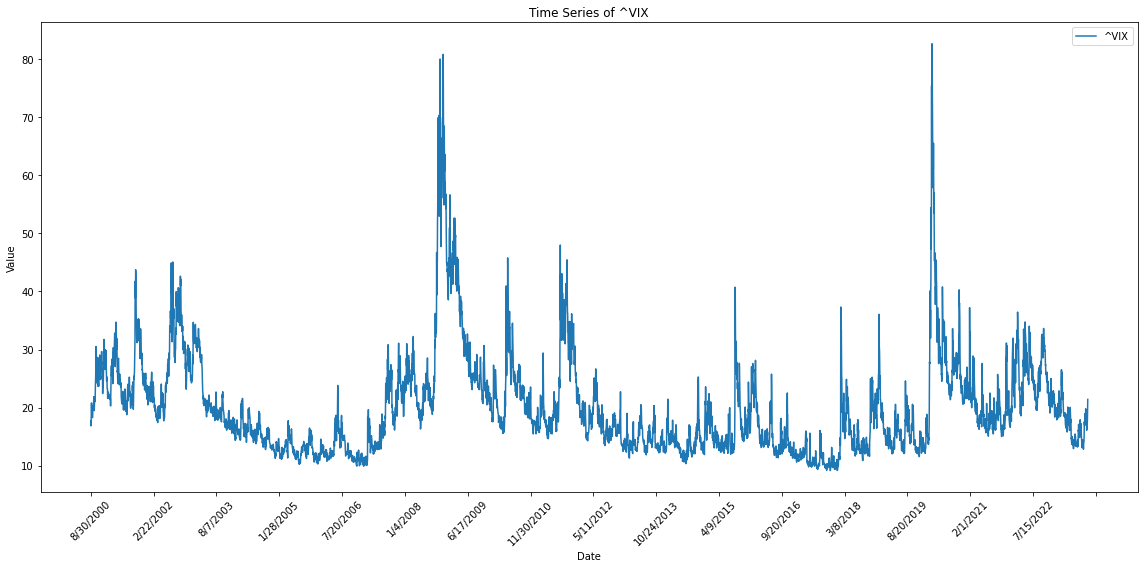

In [5]:
def plot_series(series, label, size=(16,8)):
    # Create the plot
    fig, ax = plt.subplots(figsize=size)
    ax.plot(series.index, series.values, label=label)

    # Format the x-axis
    ax.xaxis.set_major_locator(mdates.YearLocator())
    plt.xticks(rotation=45)

    # Add title, labels, and a legend
    plt.title("Time Series of {}".format(label))
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend()

    # Display the graph
    plt.tight_layout()
    plt.show()

for col in close_prices.columns:
    plot_series(close_prices[col], '{}'.format(col))


- 如上图所示，除了 ^VIX 以外，其它八个指数都有明显时间趋势。比如纳斯达克指数在过去20年涨了很多，现在的指数和20年前的指数均值完全不同。

- 除了画图以外，更严格的检查方法是利用统计假设检验。最通用的假设检验方法为 Augmented-Dickey_Fuller Test (ADF).

- 以下为执行ADF test 的Python 代码 

In [6]:
non_stationary_series = []
for col in close_prices.columns:
    result = adfuller(close_prices[col])
    print('ADF Statistic of {}:'.format(col), result[0])
    print('p-value of {}:'.format(col), result[1])
    print('Critical Values of {}:'.format(col), result[4])
    if result[0] >= result[4]['5%']: # cannot reject the null, therefore the series is likely to be nonstaionary.
        non_stationary_series.append(col)
    

ADF Statistic of CL=F: -2.6340062073440422
p-value of CL=F: 0.08617055813957225
Critical Values of CL=F: {'1%': -3.4314842254822664, '5%': -2.8620412197041305, '10%': -2.567036797329616}
ADF Statistic of DX-Y.NYB: -2.014613363772699
p-value of DX-Y.NYB: 0.28020263398138295
Critical Values of DX-Y.NYB: {'1%': -3.4314806953877275, '5%': -2.8620396600349722, '10%': -2.5670359670726235}
ADF Statistic of HG=F: -1.9939847400726216
p-value of HG=F: 0.28921679347123963
Critical Values of HG=F: {'1%': -3.4314812822100733, '5%': -2.862039919305413, '10%': -2.567036105089754}
ADF Statistic of ^DJI: 0.42316023312341183
p-value of ^DJI: 0.9823406926590825
Critical Values of ^DJI: {'1%': -3.4314846190761017, '5%': -2.862041393601955, '10%': -2.5670368899004763}
ADF Statistic of ^GSPC: 0.9951229354528691
p-value of ^GSPC: 0.9942142223883884
Critical Values of ^GSPC: {'1%': -3.4314848159754745, '5%': -2.8620414805961256, '10%': -2.56703693621}
ADF Statistic of ^IXIC: 0.756553319969496
p-value of ^IXIC

In [28]:
non_stationary_series

['CL=F', 'DX-Y.NYB', 'HG=F', '^DJI', '^GSPC', '^IXIC', '^RUT', '^TNX']

假设检验结果和通过画图得到的直觉一样，除了^VIX, 其它序列都不是stationary.

- non-stationary 时间序列一般包括几种情况：1. 具有确定时间趋势或季节性的时间序列,即时间序列为时间趋势或季节的函数。 这种情况可以通过 de-trend 或 de-seasonality将时间序列转换为stationary的序列。2. unit root。unit root 的一种特殊情况是随机游走,即 $y_t = y_{t-1} + \epsilon_t$。这种序列可以表现出一种随机的时间趋势，但是趋势不稳定，可以随机改变。如股票价格，可以在一段时间持续上涨或下跌，但这种趋势可以随机转变。
  

- 检验一个时间序列是否stationary关注的问题是这个序列表现出的时间趋势是否随机，即是否存在Unit Root。如果一个序列存在Unit Root，可以通过差分将其转换为stationary 序列。 例如一个随机游走序列$y_t = y_{t-1} + \epsilon_t$， 它的一阶差分为 $\Delta y_t = y_t - y_{t-1}=\epsilon_t$。
  

- 如果一个序列可以通过$d$阶差分转换为stationary序列，我们说这个序列为 “Integregated with order d”。
  

- ADF test基于下面这个回归模型，其中$\Delta$ 代表一阶差分。   
  
  
- ADF test 的直觉是如果一个时间序列具有Unit Root，它的一阶差分为一个stationary 序列。
  

- 通过以下这个回归模型进行unit root 检验时关注点就在$\alpha_0$ 上。在一个时间序列具有unit root 的原假设上这个回归系数为零（意味着它的一阶差分为一个stationary的序列），否则其小于零。
  

- 如果在假设检验中不能拒绝这个原假设，就有一定证据表明一个时间序列具有unit root, 从而为non-stationary。
  

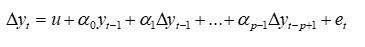
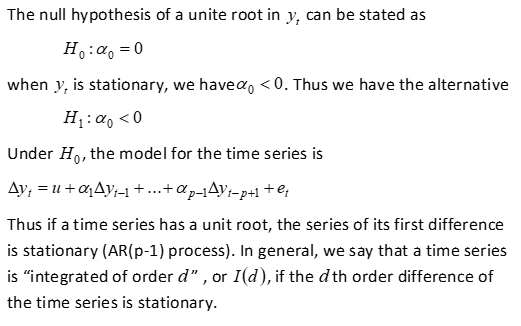

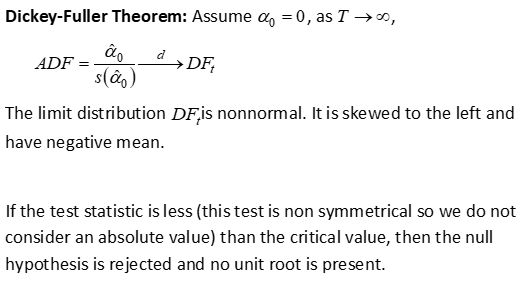

#### Stationarize time series: 一阶差分

- 对每一个non-stationary 序列， 定义其差分序列： $\Delta y_t = y_t - y_{t-1}$
  

- 这时原序列中的第一个观察值为NaN。 我们将其drop 掉。

  
- 再对差分后的序列进行ADF test。

In [8]:
data_diff = close_prices.copy()
for col in non_stationary_series:
    data_diff[col] = close_prices[col].diff()

data_diff=data_diff.dropna()
for col in close_prices.columns:
    result = adfuller(data_diff[col])
    print('ADF Statistic of {}:'.format(col), result[0])
    print('p-value of {}:'.format(col), result[1])
    print('Critical Values of {}:'.format(col), result[4])
    if result[0] >= result[4]['5%']: # cannot reject the null, therefore the series is likely to be nonstaionary.
        print('{} is still nonstationary'.format(col))
    

ADF Statistic of CL=F: -12.573785050926672
p-value of CL=F: 1.977723860227965e-23
Critical Values of CL=F: {'1%': -3.4314842254822664, '5%': -2.8620412197041305, '10%': -2.567036797329616}
ADF Statistic of DX-Y.NYB: -23.22984896737415
p-value of DX-Y.NYB: 0.0
Critical Values of DX-Y.NYB: {'1%': -3.4314806953877275, '5%': -2.8620396600349722, '10%': -2.5670359670726235}
ADF Statistic of HG=F: -19.4593578669343
p-value of HG=F: 0.0
Critical Values of HG=F: {'1%': -3.4314812822100733, '5%': -2.862039919305413, '10%': -2.567036105089754}
ADF Statistic of ^DJI: -15.771385876056819
p-value of ^DJI: 1.1598722282924054e-28
Critical Values of ^DJI: {'1%': -3.4314846190761017, '5%': -2.862041393601955, '10%': -2.5670368899004763}
ADF Statistic of ^GSPC: -15.415013505157289
p-value of ^GSPC: 3.0875955197500643e-28
Critical Values of ^GSPC: {'1%': -3.4314848159754745, '5%': -2.8620414805961256, '10%': -2.56703693621}
ADF Statistic of ^IXIC: -13.733194542322352
p-value of ^IXIC: 1.129999728271348e-

检验结果显示之前non-staionary序列在一阶差分后都变为stationary序列。

In [9]:
data_diff

,CL=F,DX-Y.NYB,HG=F,^DJI,^GSPC,^IXIC,^RUT,^TNX,^VIX
Date,,,,,,,,,
8/31/2000,-0.300003,0.459999,0.0000,112.08984,15.090088,102.540039,5.559998,-0.071,16.840000
9/1/2000,0.280003,-1.180000,0.0040,23.68066,3.089966,27.979980,4.019959,-0.054,17.530001
9/5/2000,0.419998,0.990005,0.0170,21.83008,-13.690064,-91.149902,-2.889954,0.008,19.820000
9/6/2000,1.150002,1.709999,-0.0045,50.02930,-14.829956,-129.840088,-2.700012,0.029,20.790001
9/7/2000,0.380001,-0.470001,0.0045,-50.76953,10.260010,85.010010,6.500000,0.037,19.420000
...,...,...,...,...,...,...,...,...,...
10/13/2023,4.779999,0.080002,-0.0140,39.14843,-21.830078,-166.989260,-14.540039,-0.083,19.320000
10/16/2023,-1.029999,-0.410004,0.0070,314.25000,45.850098,160.750000,27.350098,0.083,17.209999
10/17/2023,0.000000,0.010002,-0.0115,13.10938,-0.429688,-34.230470,18.989990,0.135,17.879999


差分后的数据从2000年8月31日开始，原始数据从8月30号开始。

#### 对差分后的数据画图

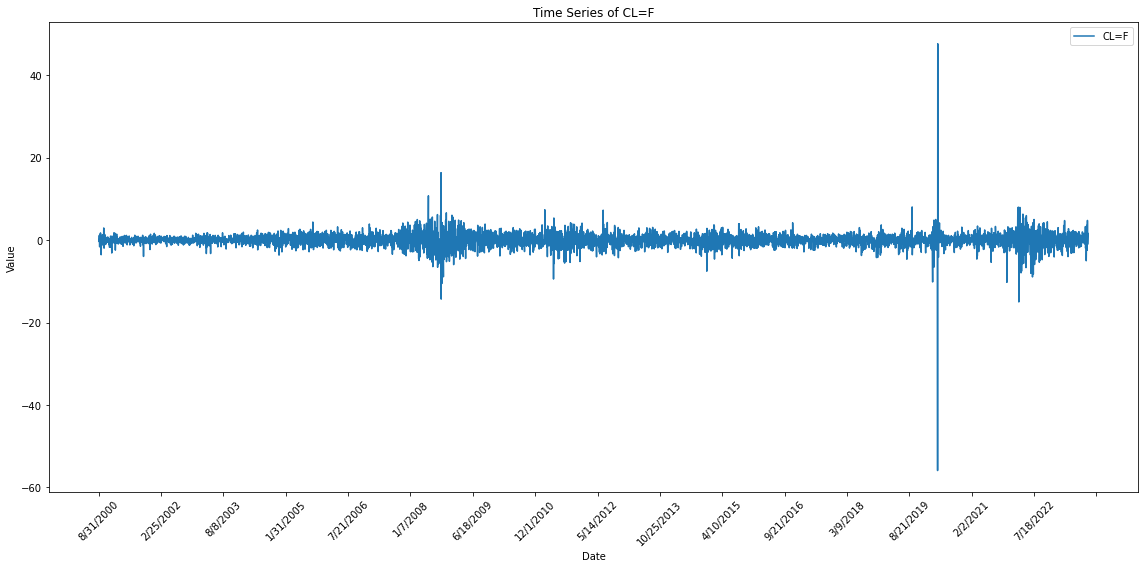

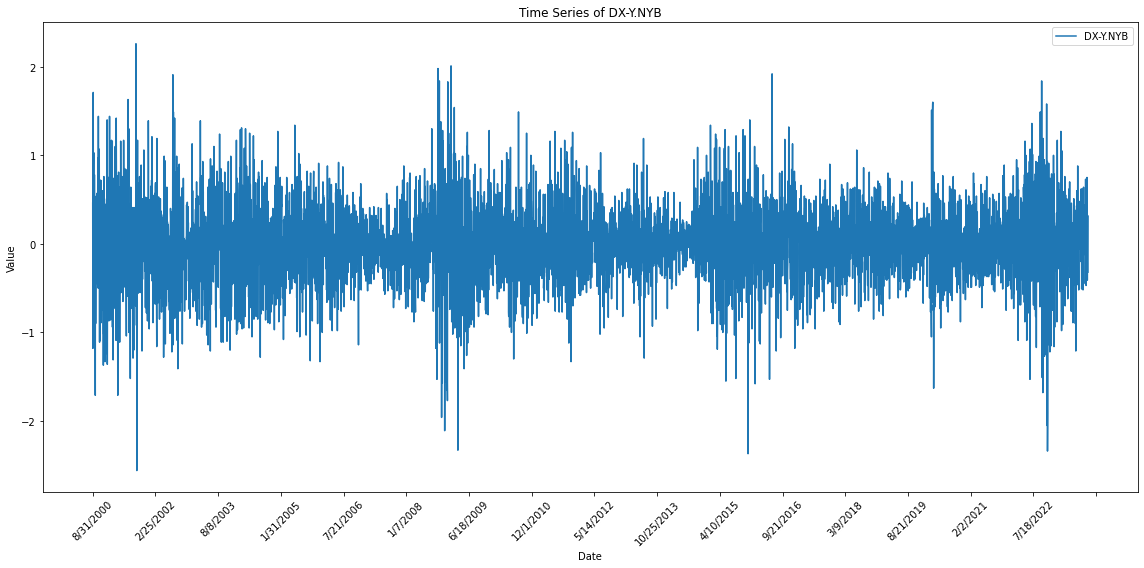

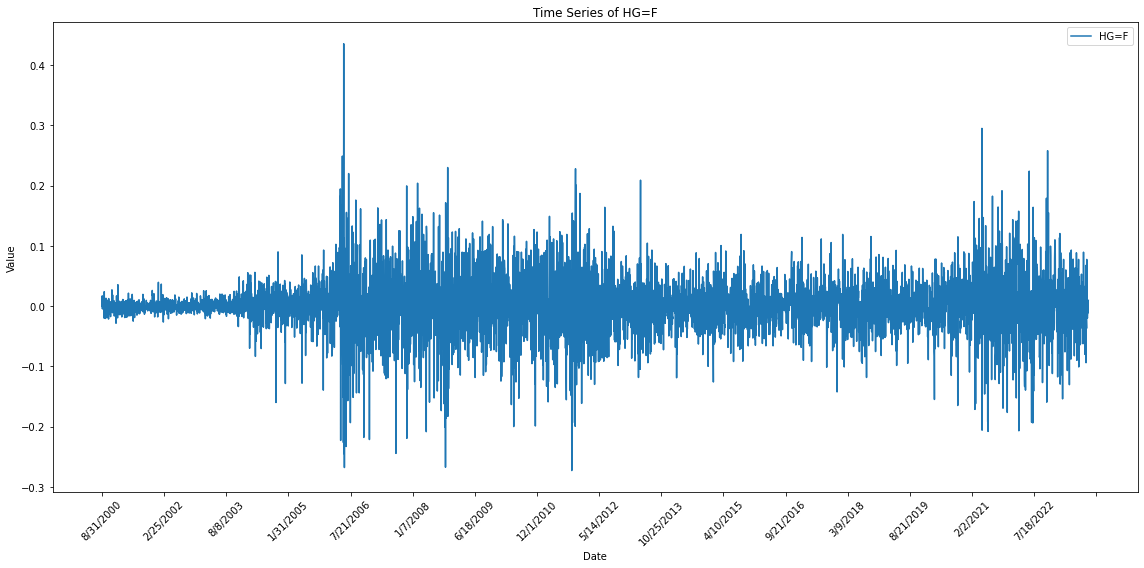

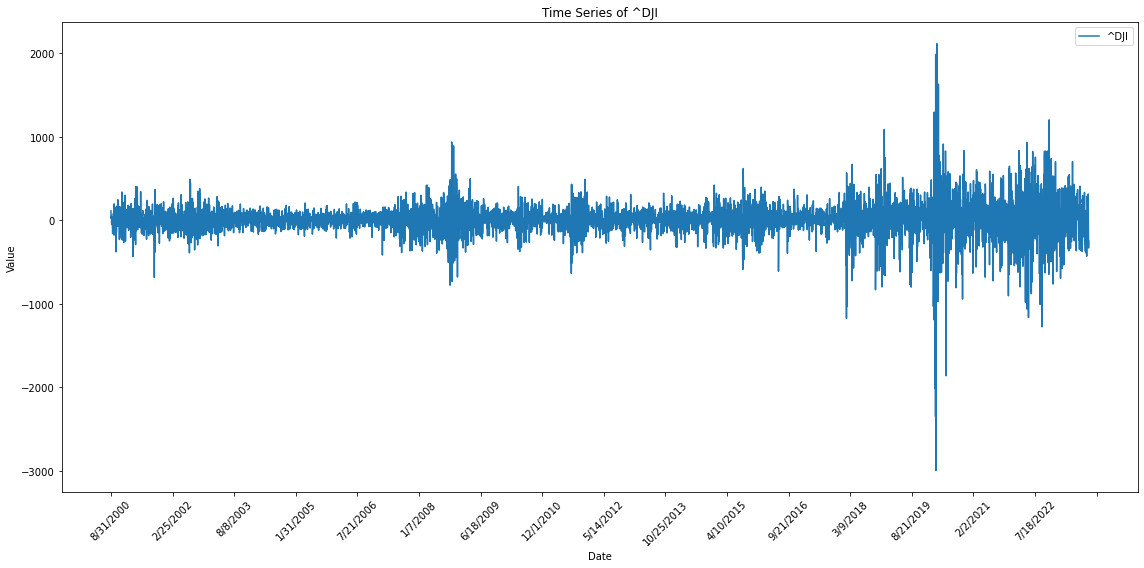

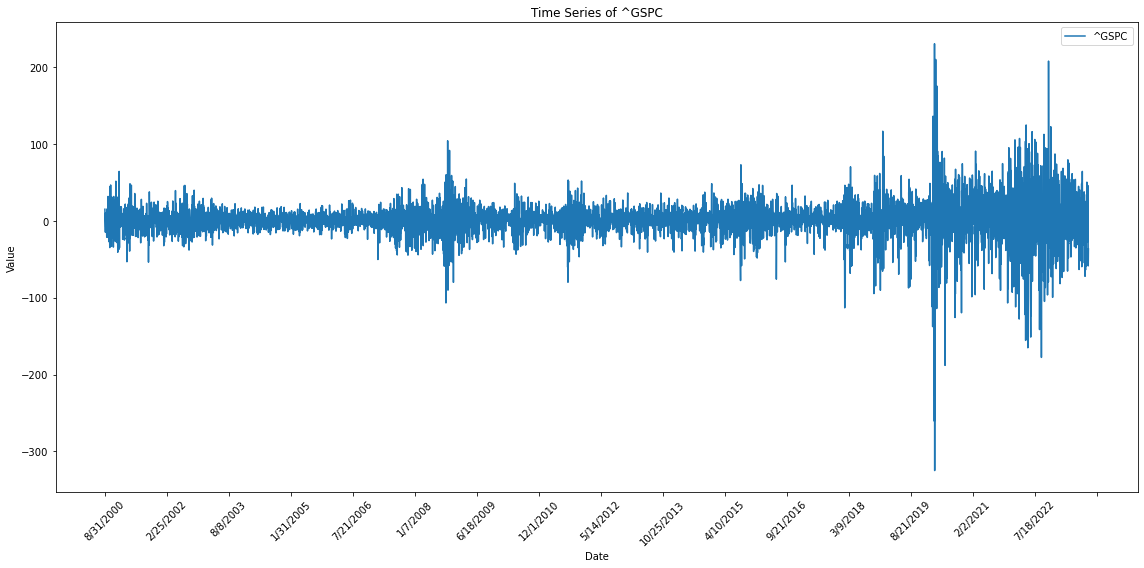

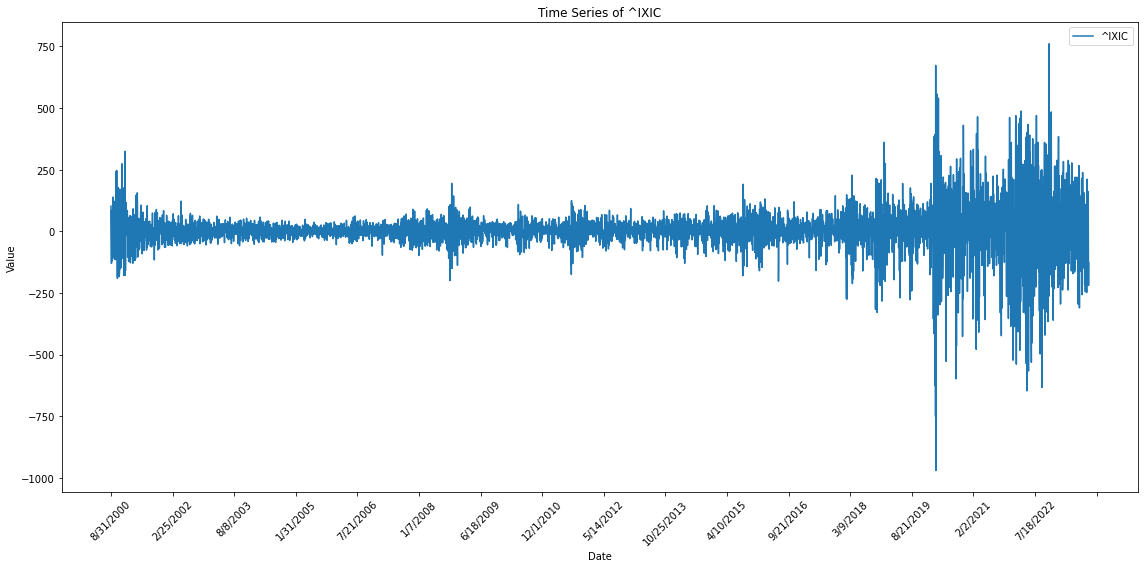

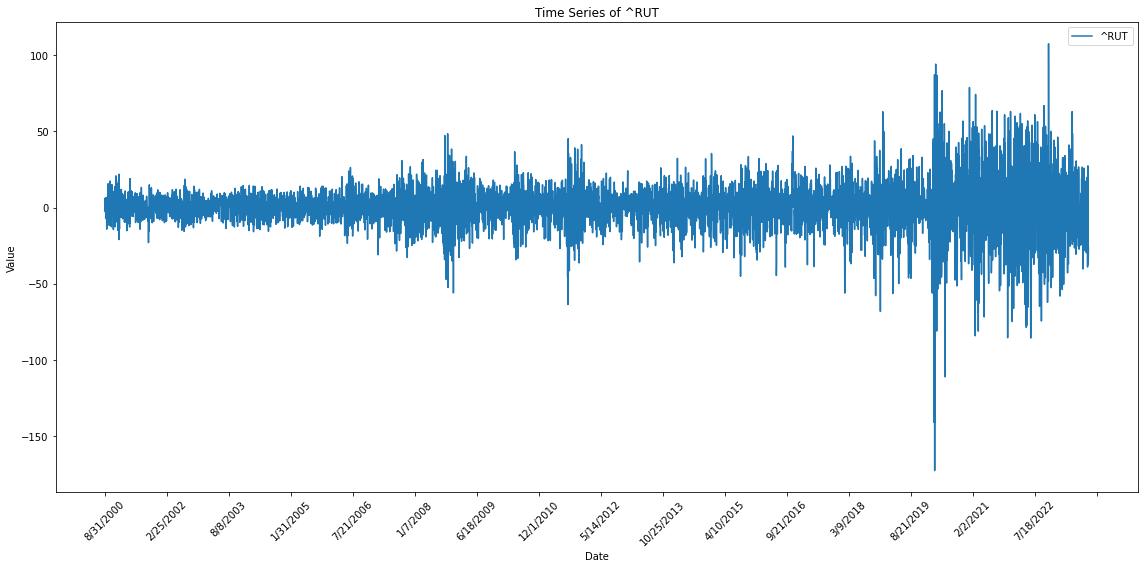

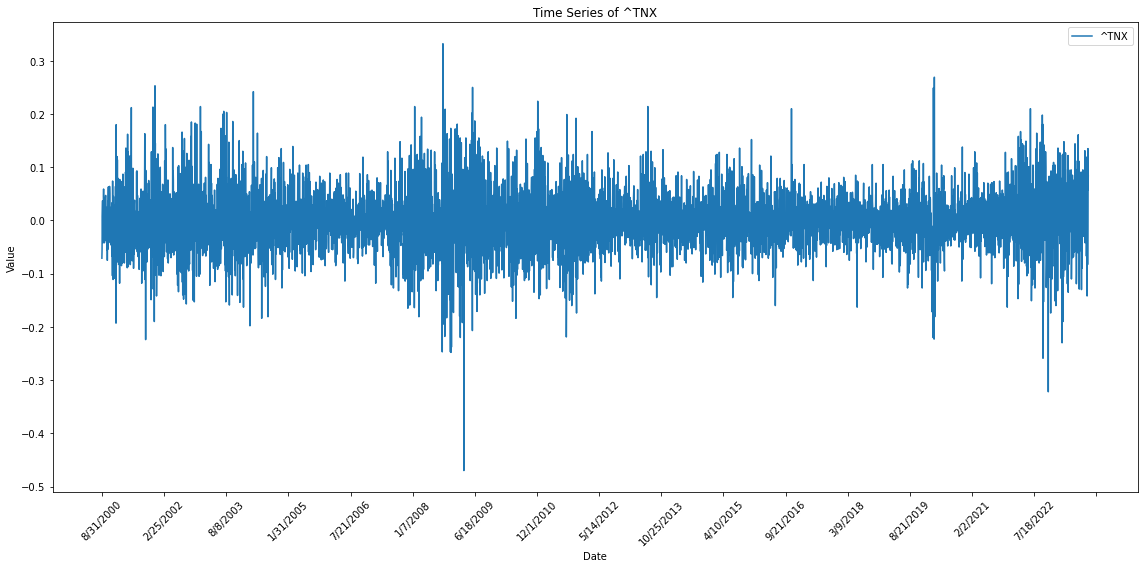

In [10]:
for col in non_stationary_series:
    plot_series(data_diff[col],'{}'.format(col))

很明显，差分后的数据基本围绕一个均值波动，不再有时间趋势.

### Train Test split for time series data

- 对时间序列建模时，训练集和测试集的划分不能再用之前的随机划分方法，不然数据的序列特征不能保存。
  
- 正确的做法是将时间段分为两部分，第一部分的序列为训练集。第二部分的序列为测试集。
  
- 时间序列模型是用序列的滞后值(lags)来预测当前值。滞后多少期是一个需要调优的超参。 在我们这个练习中每一期的目标变量是一个9维向量 $ \mathbf{y_t}$，预测这个目标变量的特征变量为 $p \times 9$ 的矩阵 $\mathbf{X_t}$，这里 $p$ 表示滞后的期限。在计量经济学中，Vector Autoregressive Models with p lags VAR(p), 是这种模型的一个特例。VAR模型限定于线性的方程形式，即 $\mathbf{y_t}= \mathbf{A}\mathbf{X_t}^T  +  \mathbf{\mu_t}$
  
- 在下面这个代码中我们设定 $p=30$, 将序列中前80%的时间点设为测试集。


In [12]:
def train_test_construction(df, ratio=0.8, lags=30, method=None):
    training_data_len = math.ceil(len(df)* ratio)
    train, test = df[0:training_data_len], df[training_data_len:]
    train_index = train.index[lags:len(train)]
    test_index = test.index[(lags-1):len(test)]
    train_data = train.values
    test_data = test.values

    scalar = scale_method(method=method)
    if scalar is None:
        pass
    else:
        train_data = scalar.fit_transform(train_data)
    x_train = []
    y_train = []

    for i in range(lags, len(train_data)):
        x_train.append(train_data[i-lags:i, :])
        y_train.append(train_data[i, :])
    x_train, y_train = np.array(x_train), np.array(y_train)
    
    if scalar is None:
        pass
    else:
        test_data = scalar.fit_transform(test_data)
    x_test = []
    y_test = df.values[training_data_len:]
    for i in range(lags, len(test_data)):
        x_test.append(test_data[i-lags:i,:])

    x_test = np.array(x_test)
    return (x_train, x_test, y_train, y_test, scalar, train_index, test_index)

def scale_method(method = 'min_max'):
    if method == "min_max":
        scaler = MinMaxScaler(feature_range=(0,1))
    if method == "standard":
        scalar = StandardScaler()
    if method is None:
        scaler = None
    return scaler    
    

x_train, x_test, y_train, y_test, scaler, train_dates_index, test_dates_index = train_test_construction(data_diff, ratio=0.8, lags=30)
print('Diminesion of feature data:', x_train.shape)
print('Diminesion of target data:', y_train.shape)


Diminesion of feature data: (4608, 30, 9)
Diminesion of target data: (4608, 9)


#### Flatten freature tensor

In [13]:
x_train = x_train.reshape((x_train.shape[0], -1))
x_test = x_test.reshape((x_test.shape[0], -1))
x_test.shape

(1129, 270)

#### 对比不同模型的预测效果

- 线性回归。这个模型正是计量经济学中的 VAR(30) 模型。
  
- 决策树
  
- 随机森林
  
- K-最近邻
  
后三种非参数算法的直观解释为给定测试集中的一个日期，到训练集中去寻找最相似的日子进行预测。


In [15]:
def prediction_models(model_name,x_train,y_train,x_test):
    starting_date = test_dates_index[0]
    if model_name == 'linear_reg':
        model = LinearRegression()
    if model_name == 'rf':
        model = RandomForestRegressor(n_estimators=50, min_samples_leaf=5)
    if model_name == 'dt':
        model = DecisionTreeRegressor(min_samples_leaf=5)
    if model_name == 'knn':
        scalar = scale_method(method = 'min_max')
        x_train = scalar.fit_transform(x_train)
        x_test = scalar.fit_transform(x_test) 
        model = KNeighborsRegressor(n_neighbors=5)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    df = pd.DataFrame(y_pred, columns=data_diff.columns, index=test_dates_index[1:])
    df[non_stationary_series] = df[non_stationary_series].cumsum() + close_prices[non_stationary_series].loc[starting_date]
    return df

forecast_original_space = prediction_models('linear_reg',x_train,y_train,x_test) 

In [86]:
forecast_original_space

,CL=F,DX-Y.NYB,HG=F,^DJI,^GSPC,^IXIC,^RUT,^TNX,^VIX
Date,,,,,,,,,
4/29/2019,63.329997,98.184004,2.978900,26574.749614,2941.455860,8142.831836,1588.682006,2.496800,10.588
4/30/2019,63.531998,98.152003,2.977900,26635.245710,2948.907886,8182.791797,1594.586010,2.501000,10.322
5/1/2019,62.919996,98.156003,2.986300,26647.539070,2951.073877,8186.097852,1596.406005,2.498200,10.504
5/2/2019,62.917998,98.200002,2.993600,26649.116022,2949.913867,8185.255762,1591.415990,2.484800,10.922
5/3/2019,62.985996,98.262003,2.983100,26697.256258,2955.511816,8197.441797,1594.319994,2.500200,10.896
...,...,...,...,...,...,...,...,...,...
10/13/2023,-22.938013,120.969940,5.651301,37651.869181,3976.586239,11060.805063,1503.622944,8.162599,12.244
10/16/2023,-23.566013,121.067941,5.657301,37629.679729,3973.140267,11048.803012,1496.668927,8.143799,11.872
10/17/2023,-23.150013,120.869942,5.622601,37612.883633,3972.710238,11049.717124,1495.094916,8.147599,12.058


上面数据显示的为 VAR(30)在测试集的预测结果

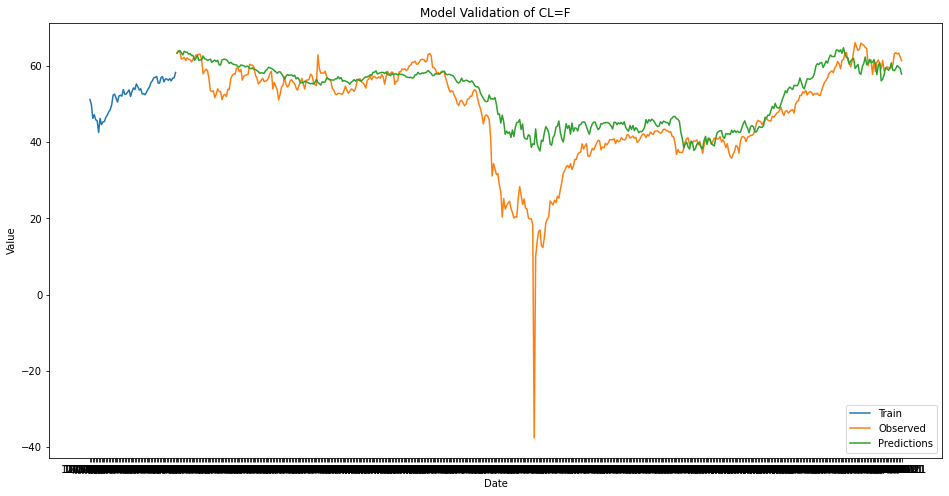

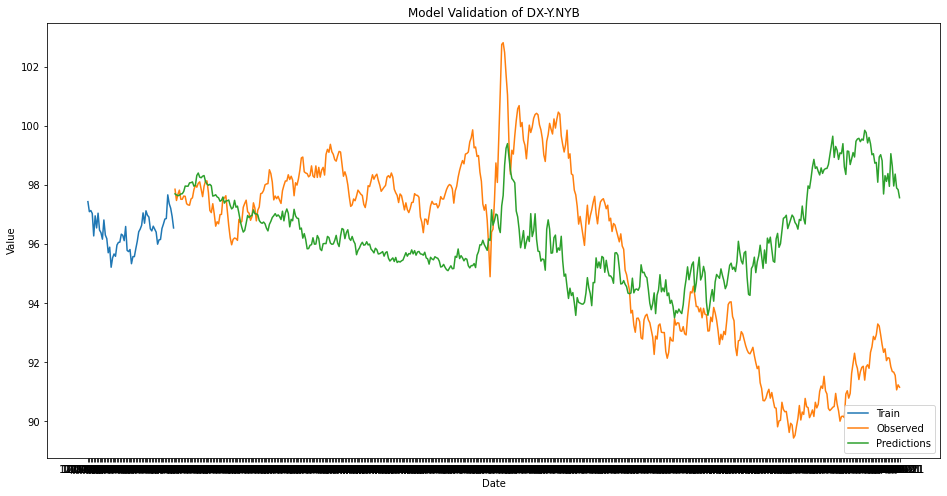

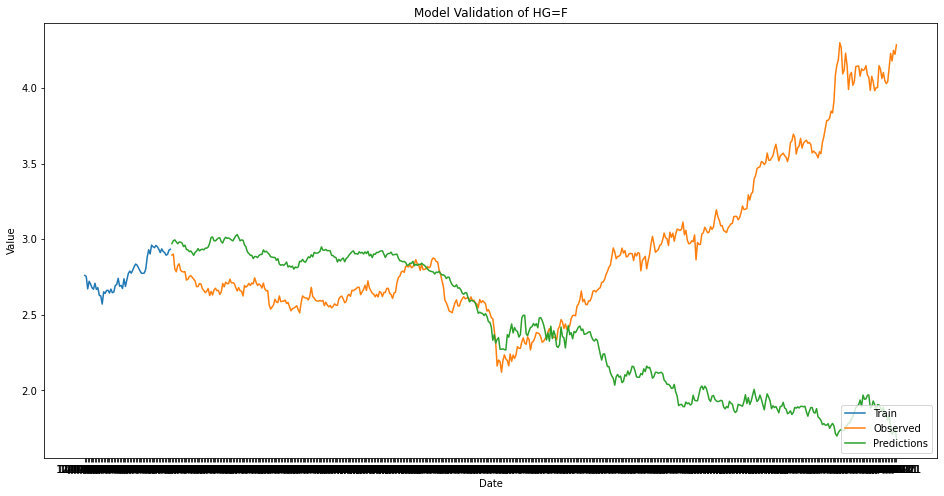

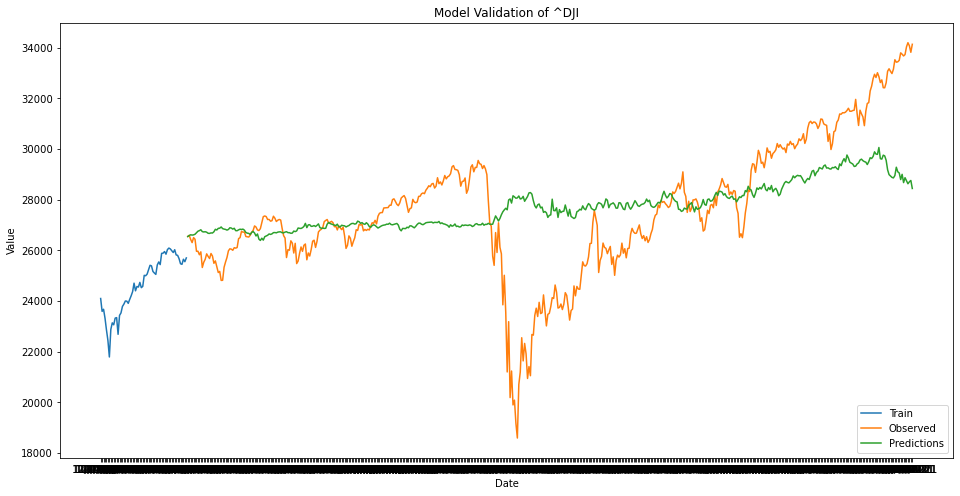

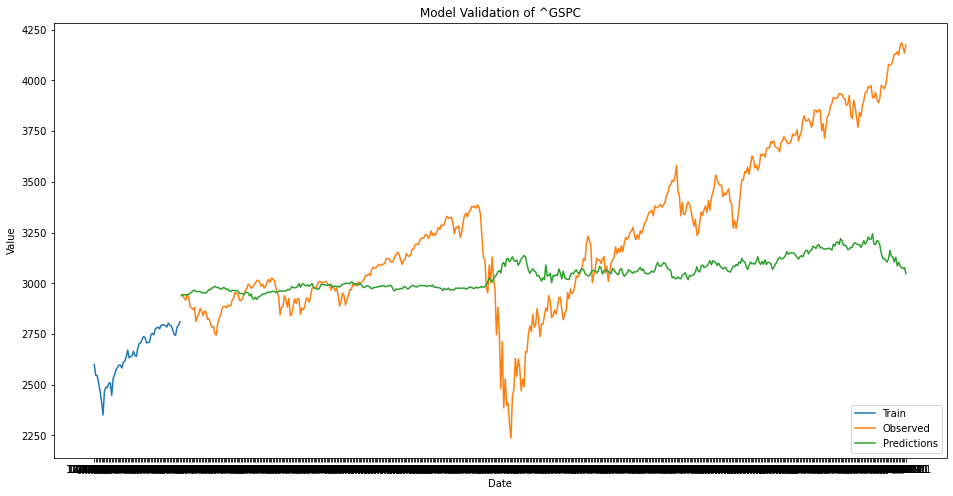

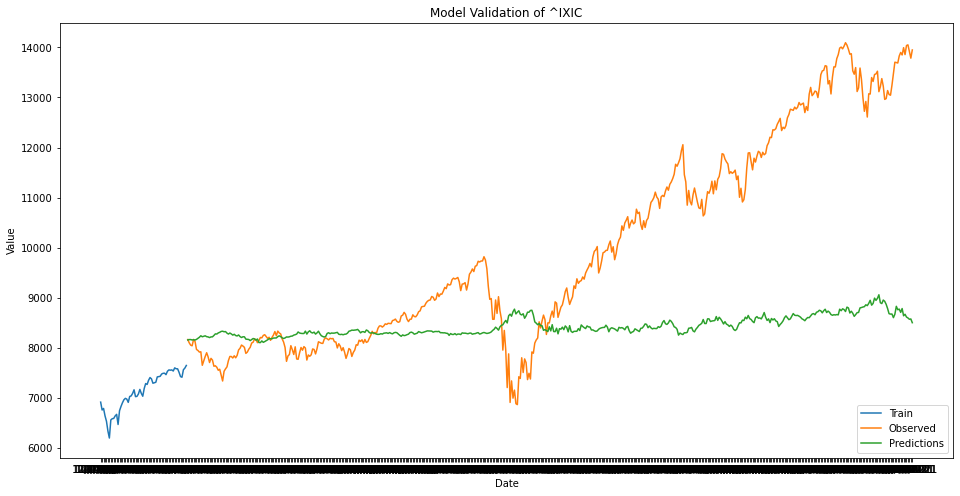

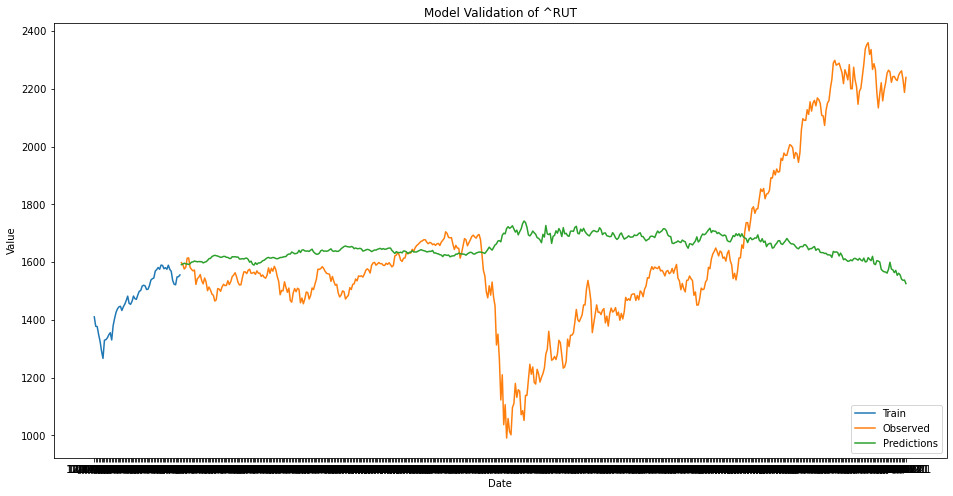

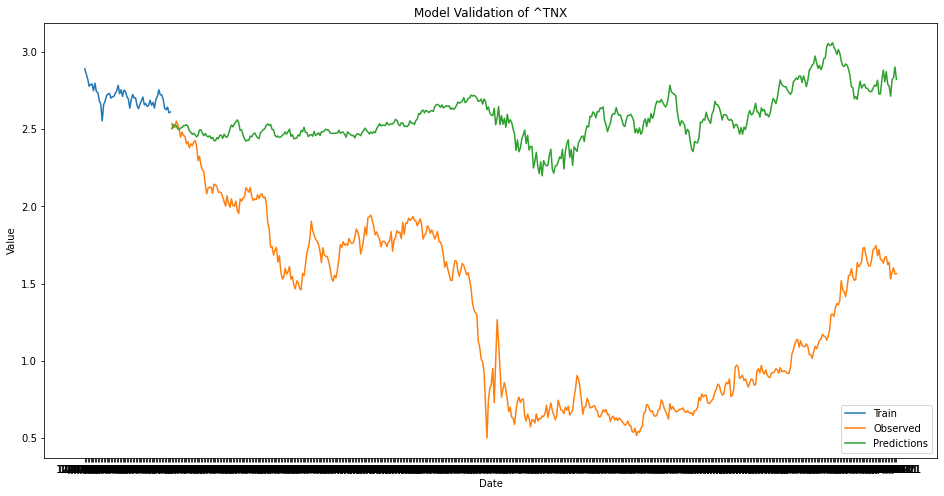

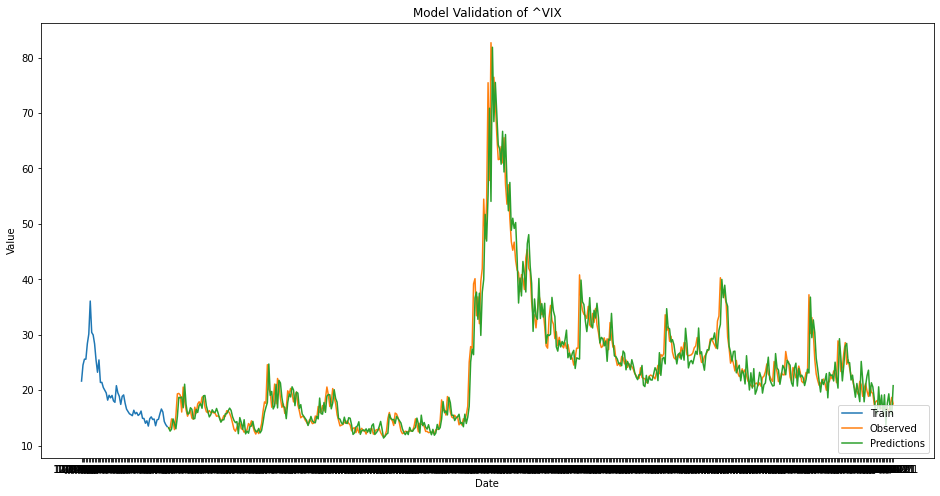

In [18]:
def validation_plot(series_name, prediction_window=100, model_lags=30):
    data_plt = pd.DataFrame(close_prices[series_name], index=close_prices.index)
    train = data_plt[:(len(train_dates_index)+model_lags)]
    validation = data_plt.loc[test_dates_index[1:]].copy()
    validation['Predictions'] = forecast_original_space[series_name]
    plt.figure(figsize=(16,8))
    plt.title('Model Validation of {}'.format(series_name))
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.plot(train[-60:])
    plt.plot(validation[validation.columns][0:prediction_window])
    plt.legend(['Train', 'Observed', 'Predictions'], loc='lower right')
    plt.show()
    return validation

for col in forecast_original_space.columns:
    val = validation_plot(col, prediction_window=500, model_lags=30)

图中蓝线为测试期的实际观测数据。黄线为测试期的实际观测数据。绿线为模型在测试期的预测值。VAR模型对VIX的预测不错。

对比一下KNN的预测

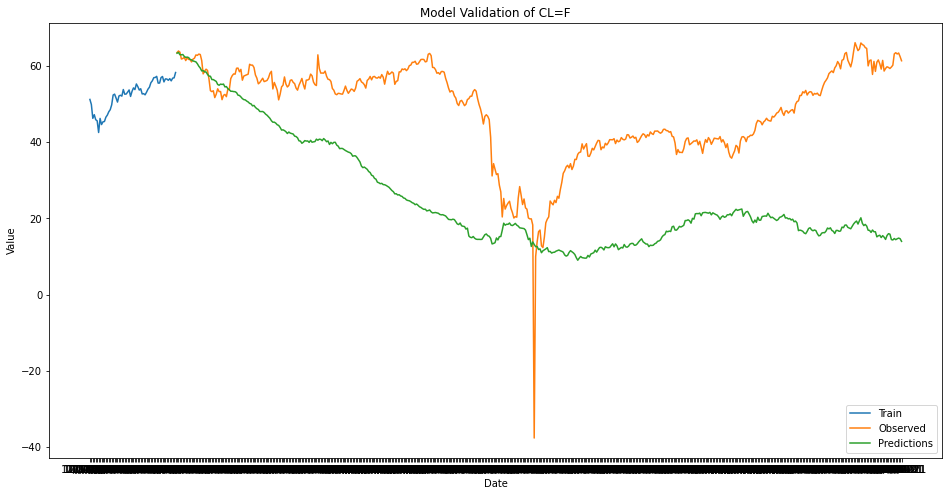

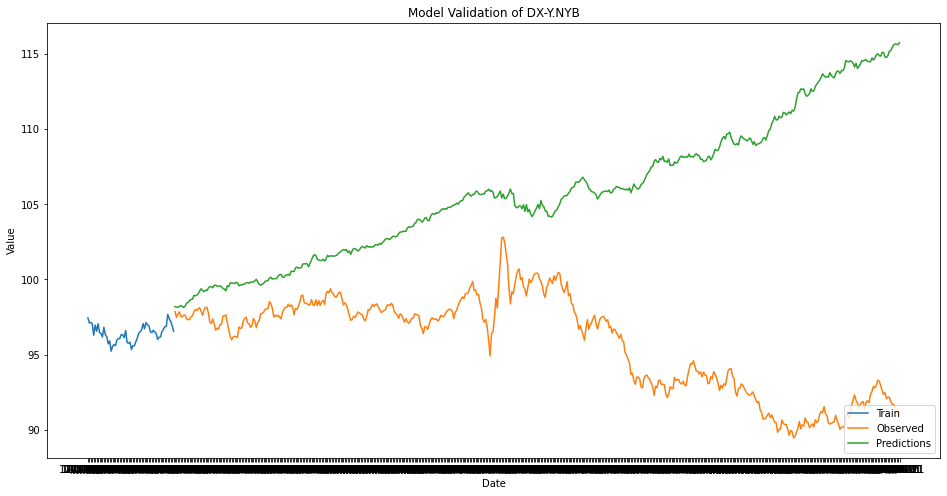

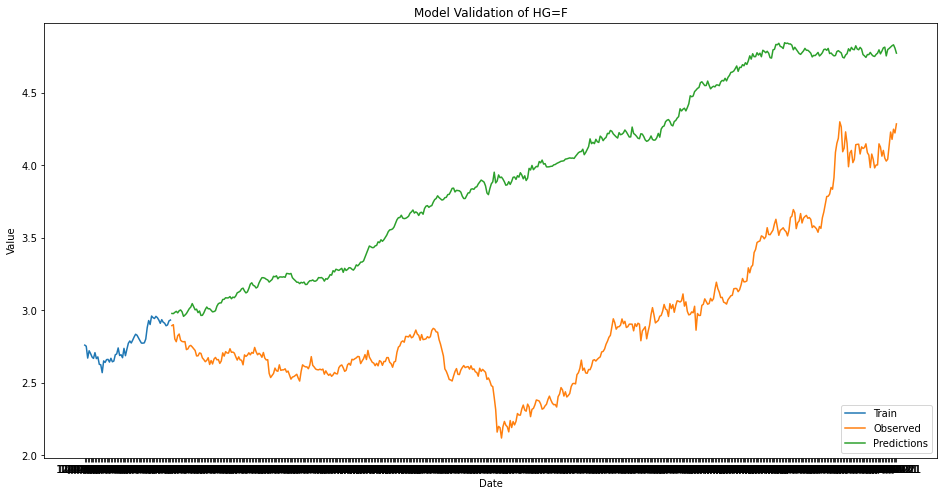

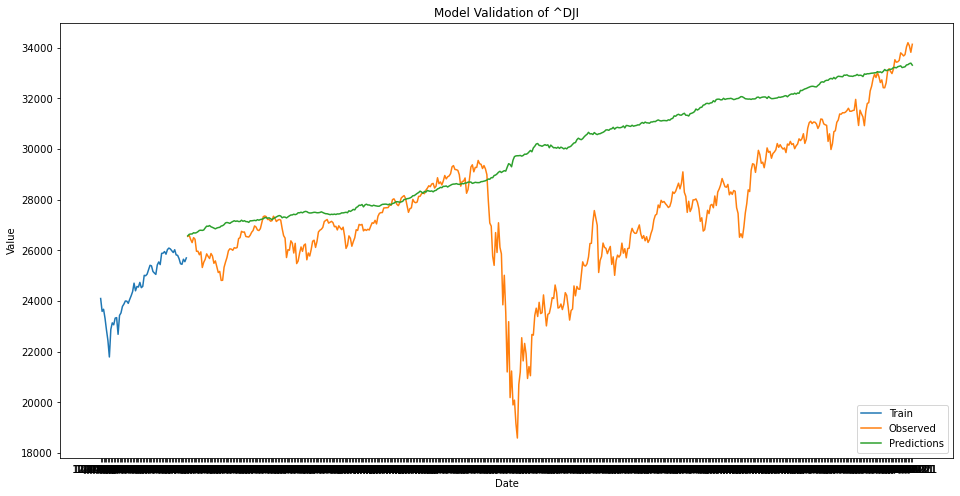

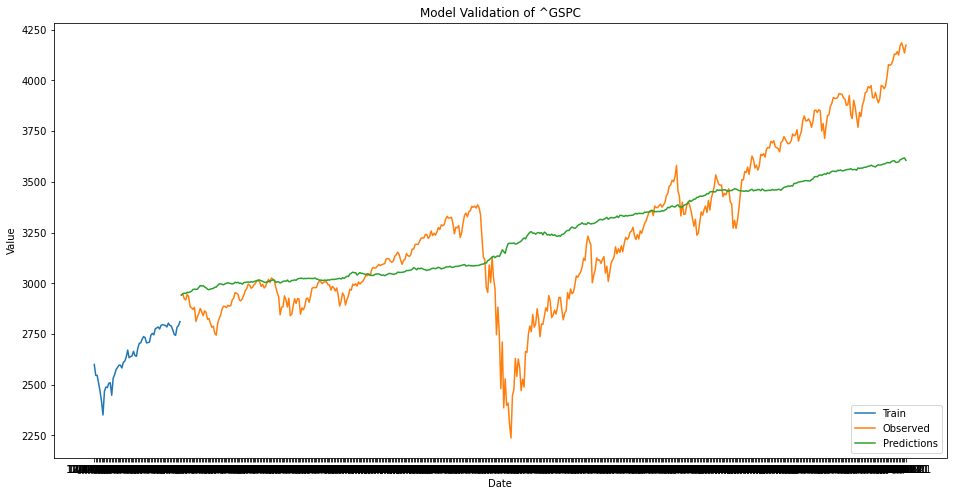

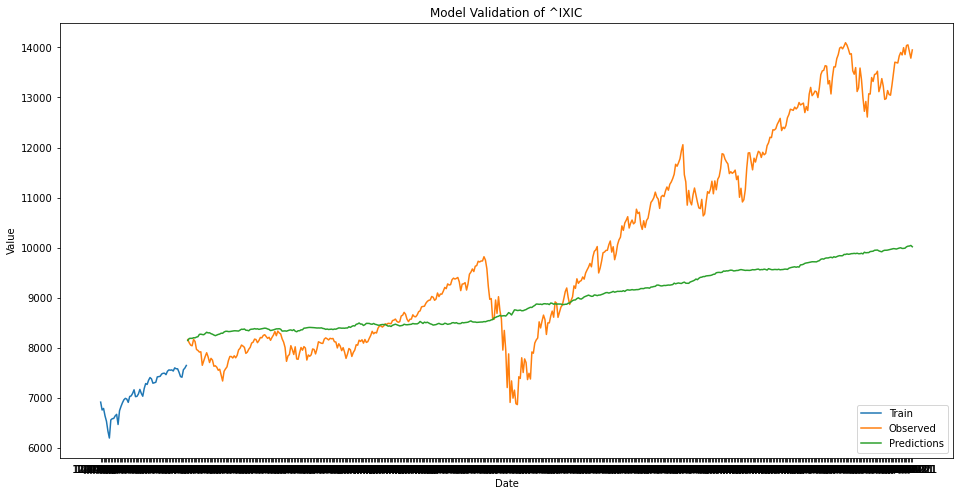

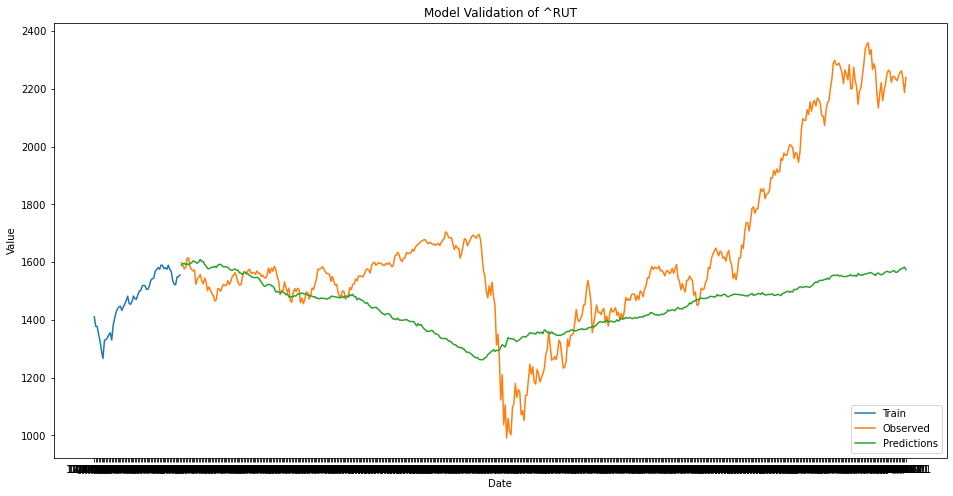

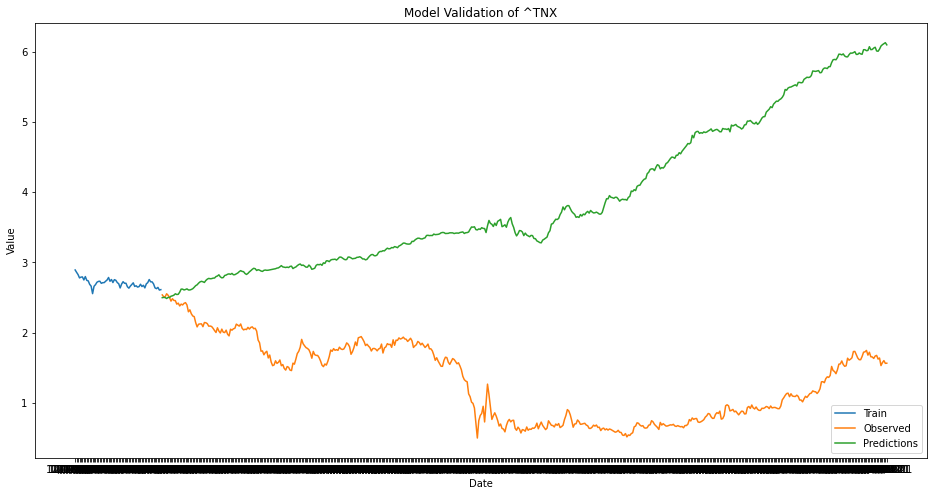

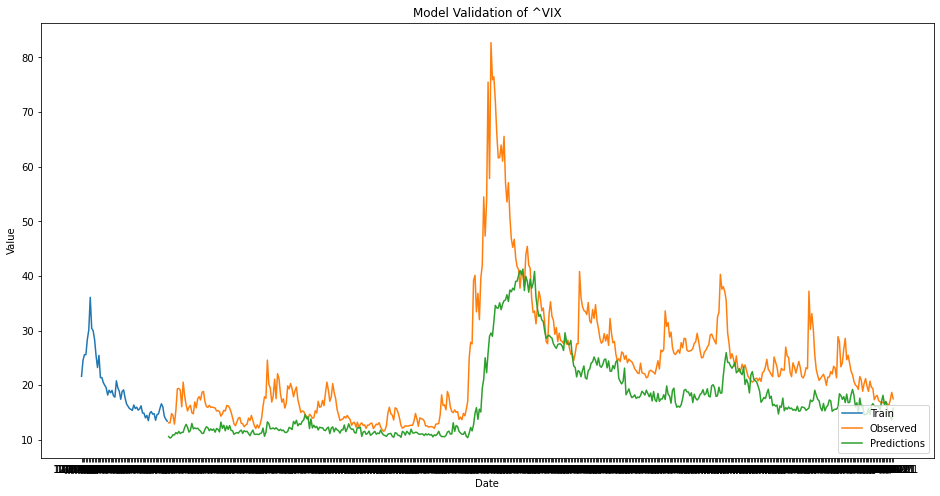

In [19]:
forecast_original_space = prediction_models('knn',x_train,y_train,x_test) 
for col in forecast_original_space.columns:
    val = validation_plot(col, prediction_window=500, model_lags=30)

对比一下决策树的预测结果

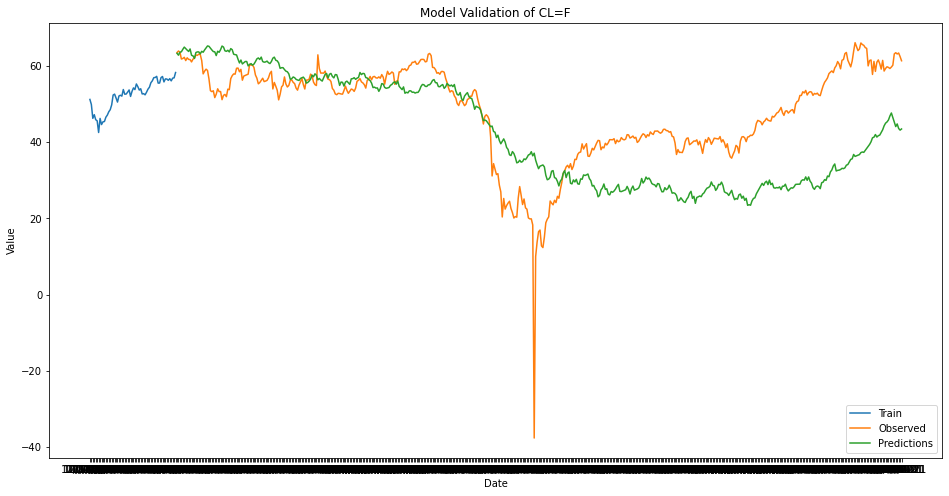

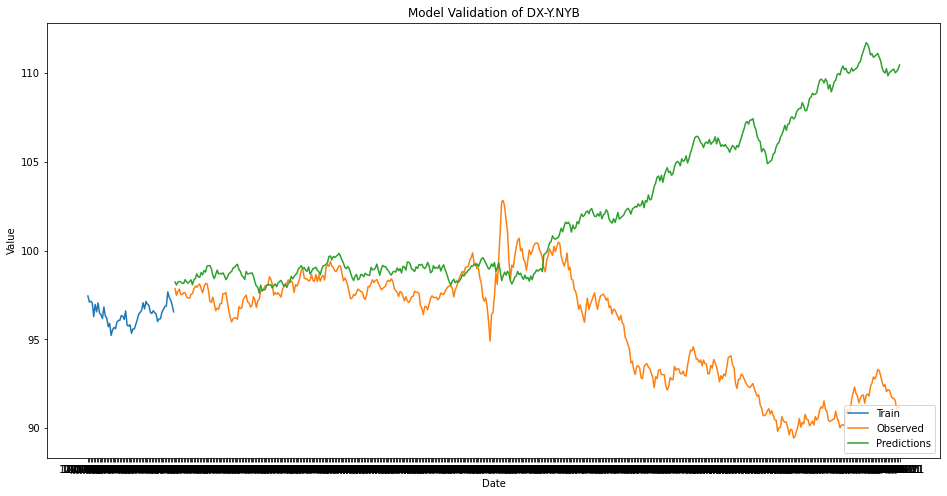

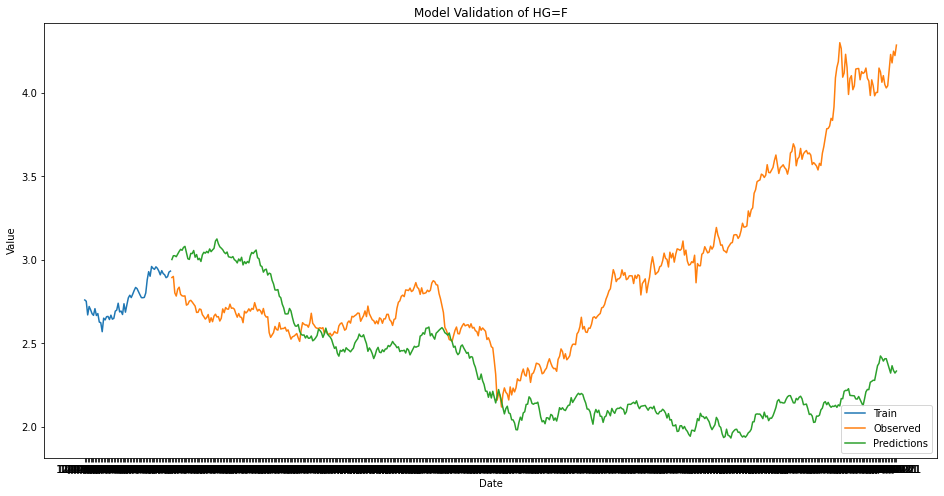

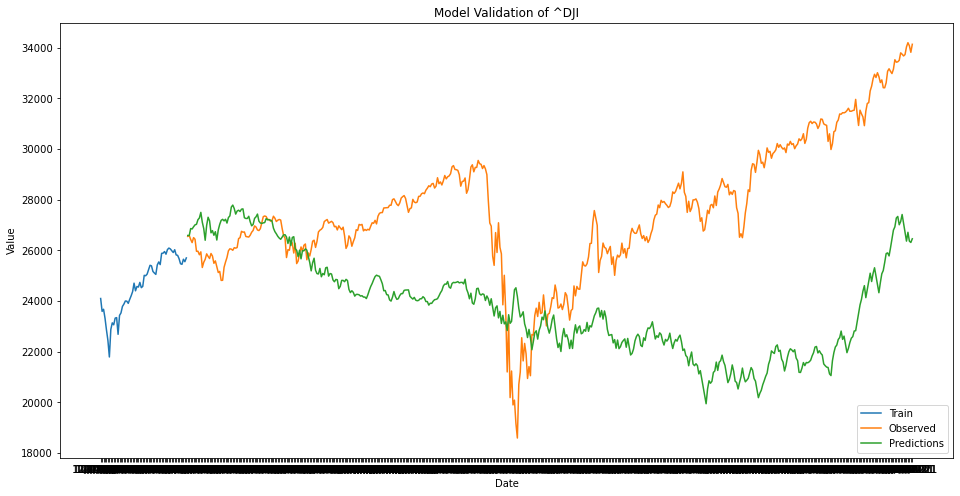

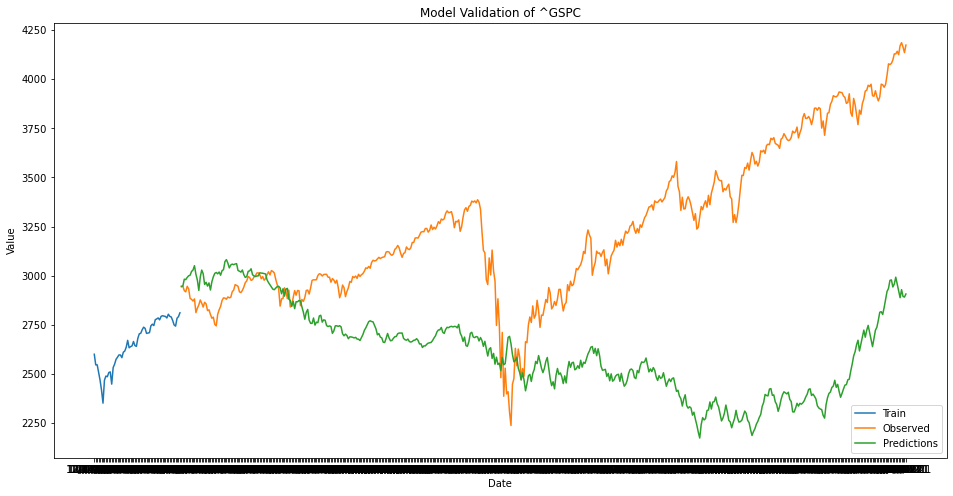

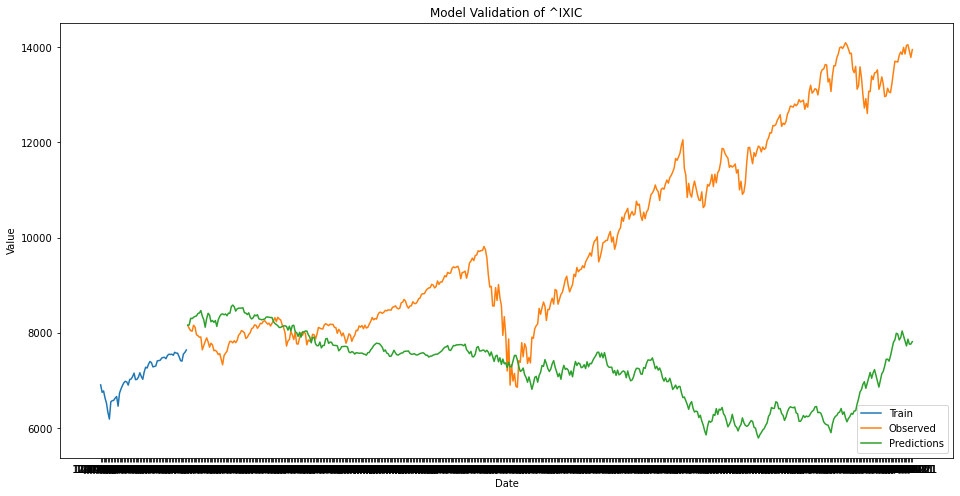

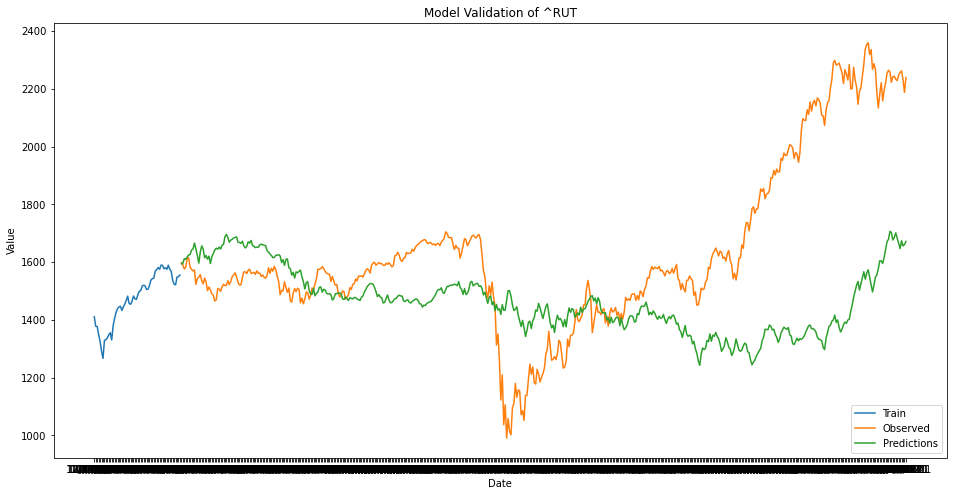

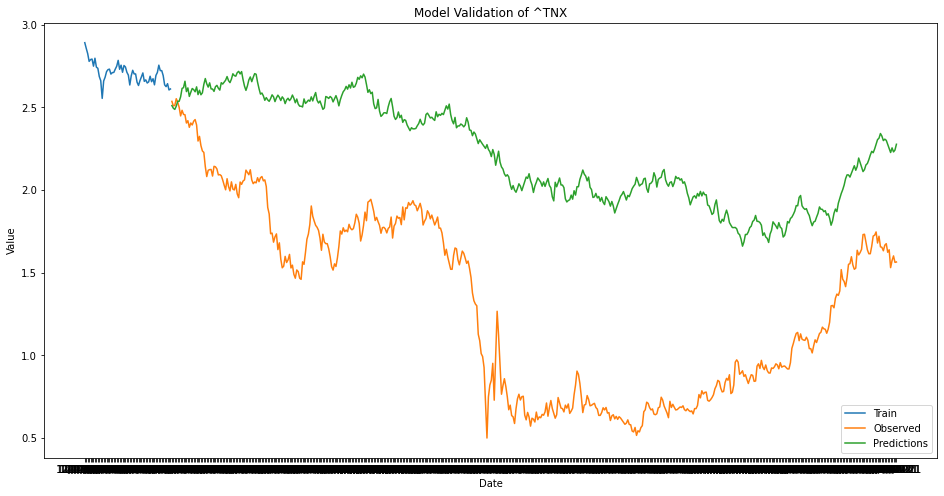

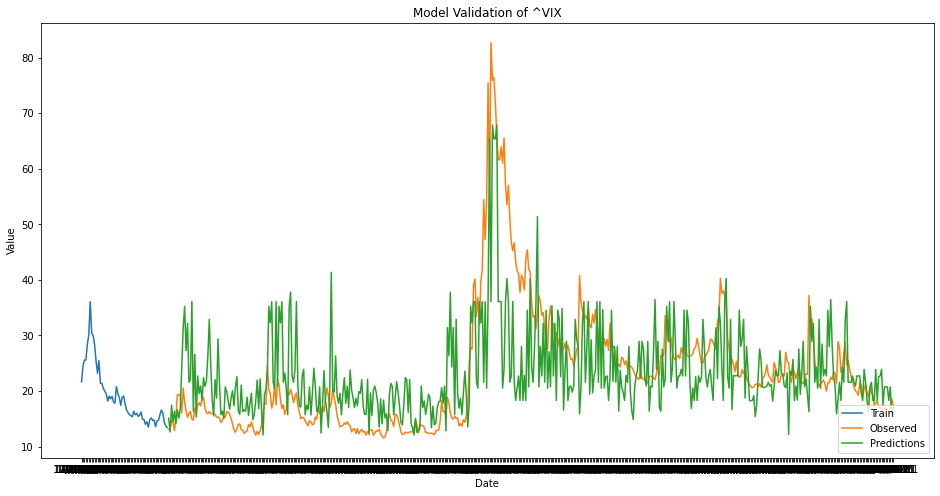

In [20]:
forecast_original_space = prediction_models('dt',x_train,y_train,x_test) 
for col in forecast_original_space.columns:
    val = validation_plot(col, prediction_window=500, model_lags=30)

最后对比一下随机森林的预测结果

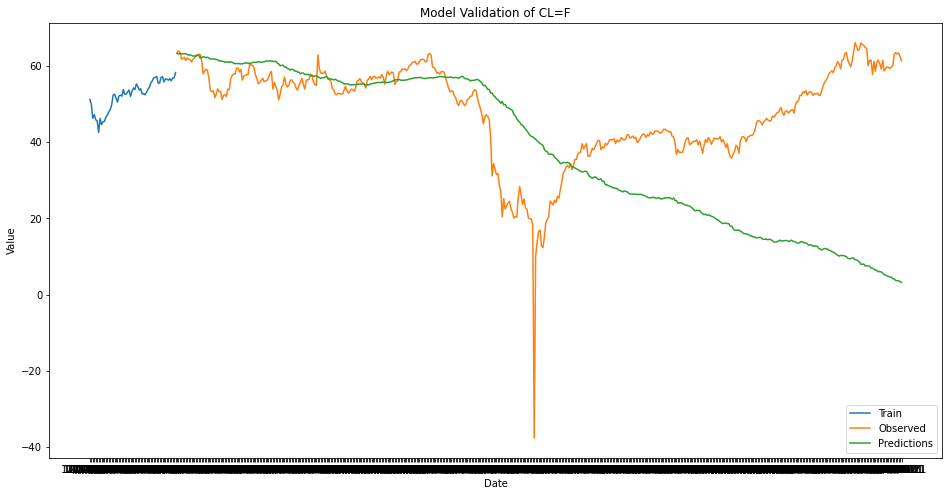

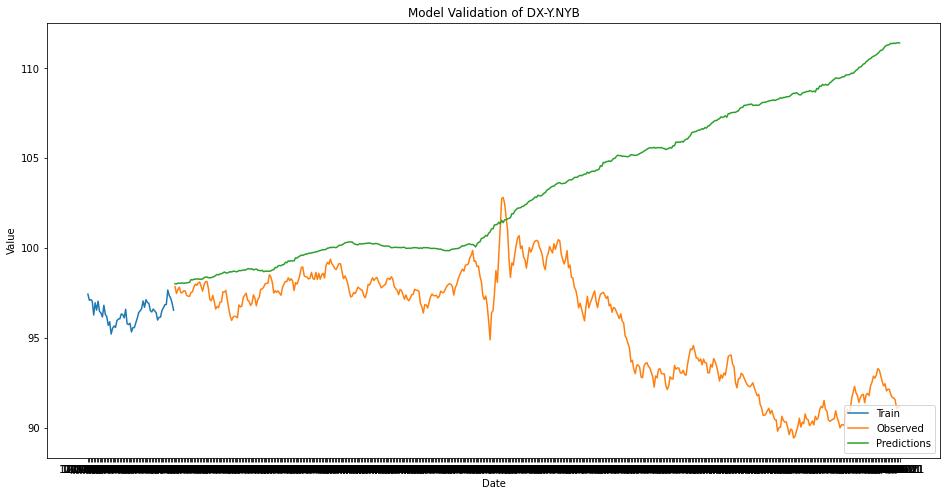

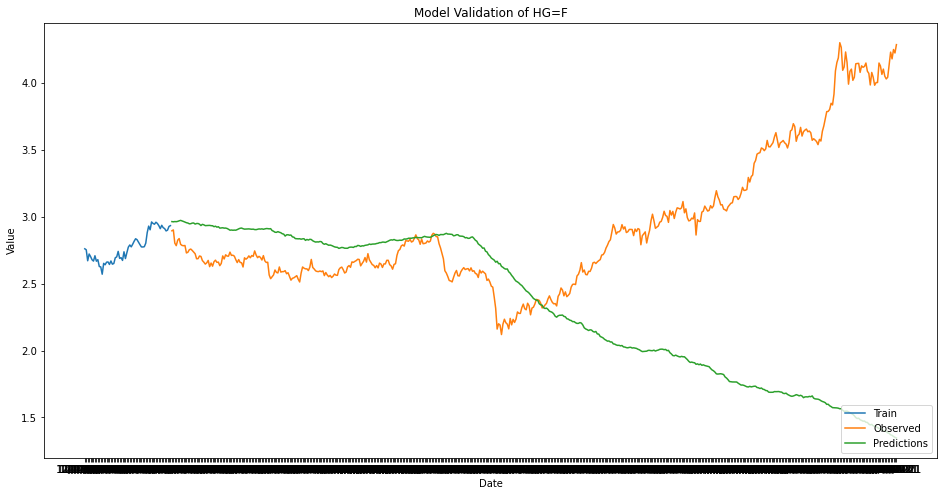

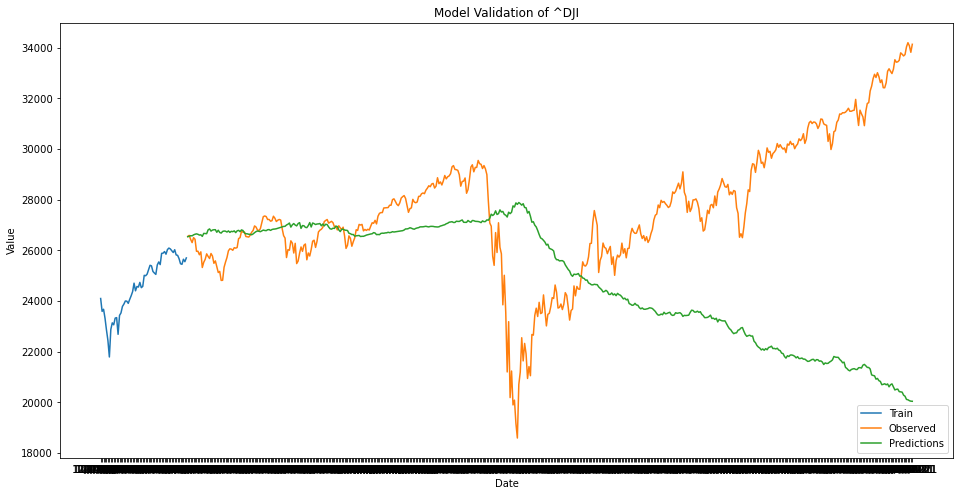

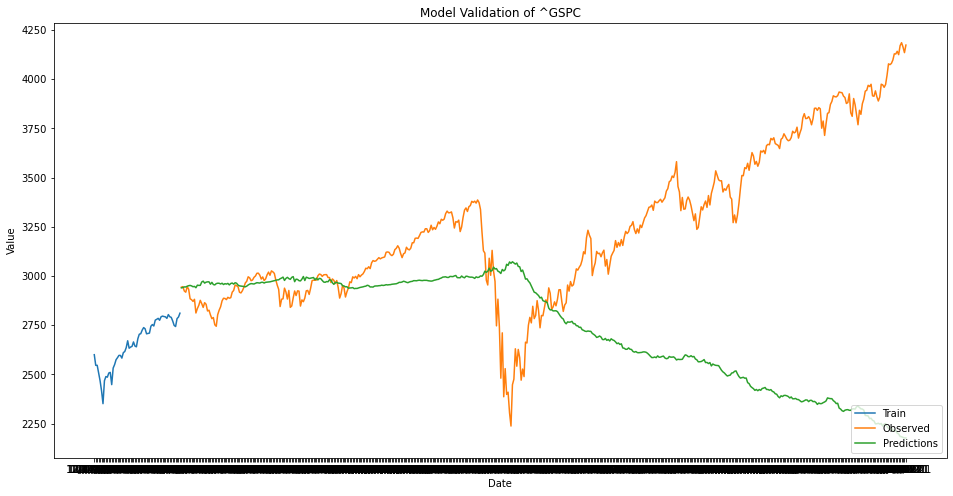

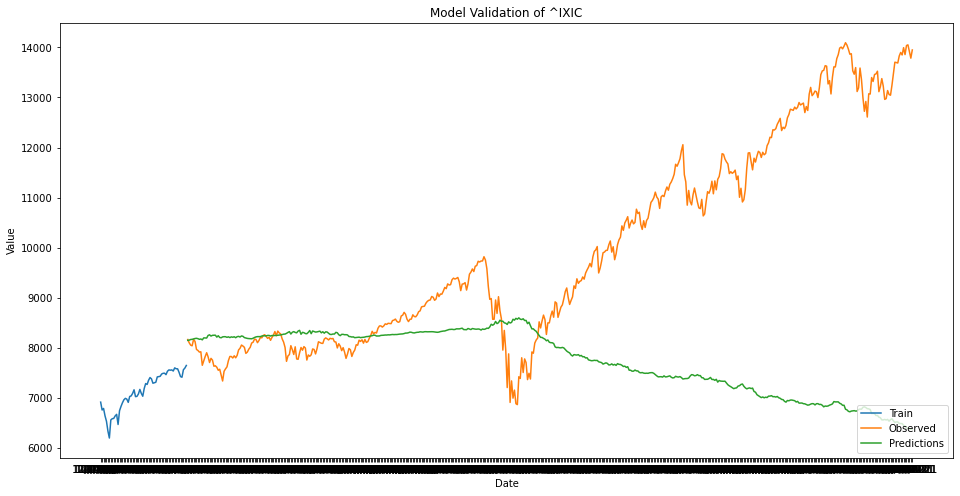

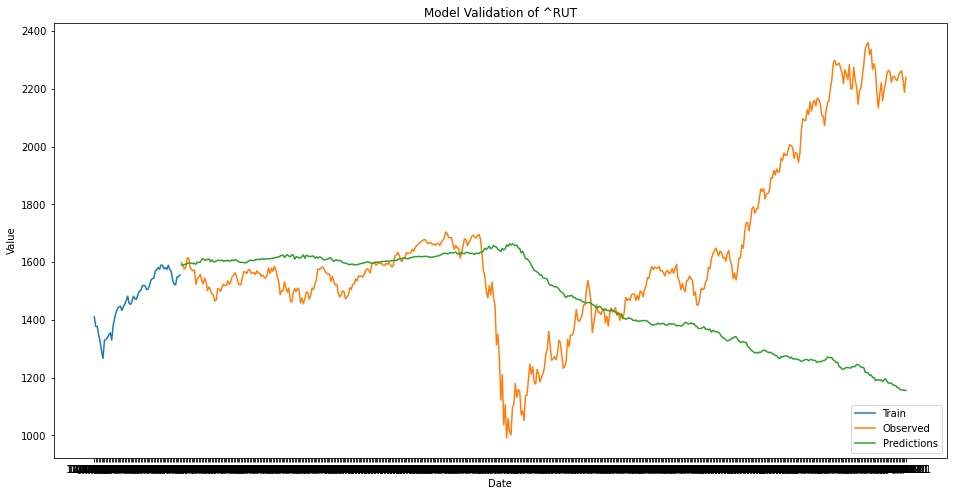

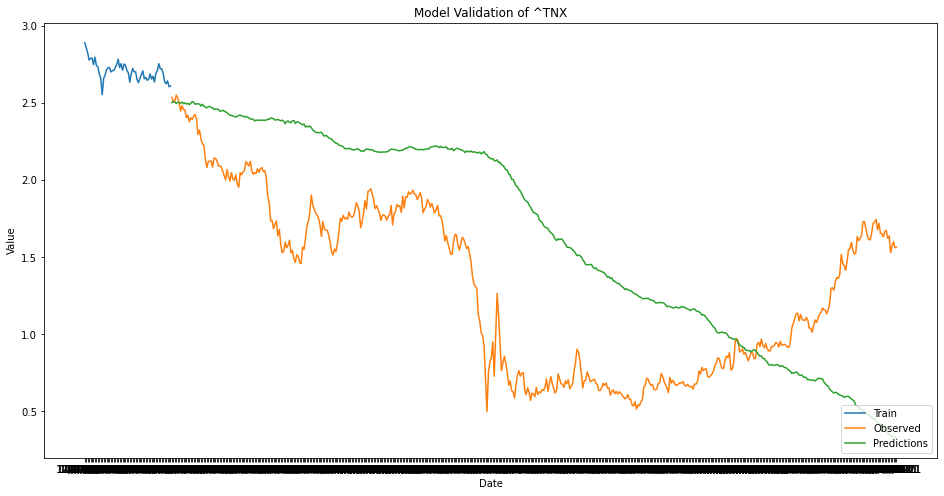

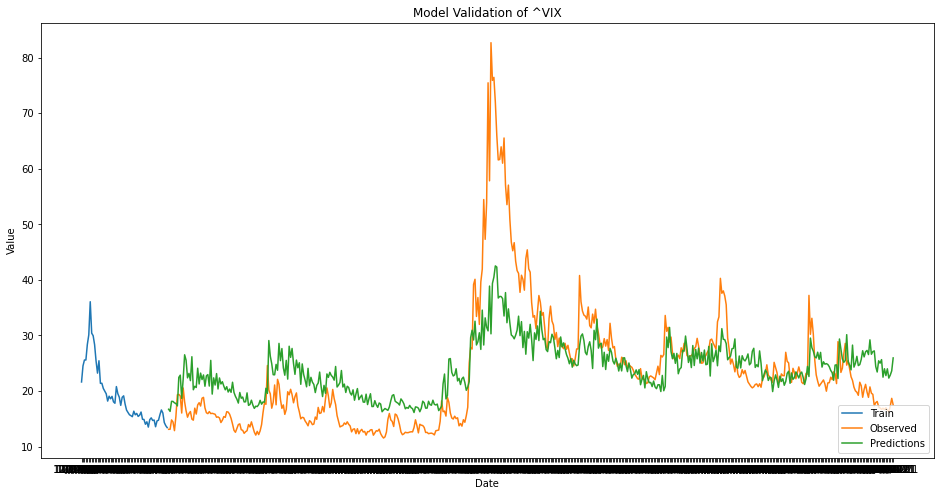

In [21]:
forecast_original_space = prediction_models('rf',x_train,y_train,x_test) 
for col in forecast_original_space.columns:
    val = validation_plot(col, prediction_window=500, model_lags=30)

随机森林模型在远期的预测效果较差，看起来受到疫情期间股市大起大落造成的非常规的数据影响较大。当然各个模型都有许多超参需要调优。 